In [1]:
# Mount Google Drive if using Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler


In [3]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define input directory (only Medical Expert-I)
expert1_dir = "/content/drive/MyDrive/MedicalExpert-I"

# Output directory for processed images
output_directory = "/content/drive/MyDrive/processed_knee_xrays_expert1"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Function to crop the knee joint ROI
def crop_knee_joint(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = image[y:y+h, x:x+w]
        return cv2.resize(roi, (224, 224))  # Resize to match input size
    else:
        return cv2.resize(image, (224, 224))  # Default to resized full image

# Function for knee-focused augmentation
def augment_knee_joint(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    alpha = np.random.uniform(0.8, 1.2)  # Contrast control
    beta = np.random.randint(-20, 20)    # Brightness control
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return image

# Function to perform basic augmentation
def augment_image(image):
    augmented_images = [
        cv2.flip(image, 1),  # Horizontal flip
        cv2.flip(image, 0),  # Vertical flip
        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
        cv2.rotate(image, cv2.ROTATE_180)
    ]
    return augmented_images

# Function to apply extra augmentation for Mild & Doubtful classes
def extra_augment_image(image):
    extra_augmented_images = [
        cv2.GaussianBlur(image, (5, 5), 0),  # Gaussian Blur
        cv2.addWeighted(image, 1.5, np.zeros_like(image), 0, -30),  # Contrast Adjustment
        cv2.GaussianBlur(image, (3, 3), 0),
        cv2.addWeighted(image, 1.3, np.zeros_like(image), 0, -20)
    ]
    return extra_augmented_images

# Store image data in a list
image_data = []

# Process images and apply augmentation
def process_images(source_dir, prefix):
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    input_path = os.path.join(category_path, filename)

                    # Read image
                    img = cv2.imread(input_path)
                    if img is None:
                        continue  # Skip corrupted images

                    # Crop knee joint
                    img = crop_knee_joint(img)

                    # Apply knee-focused augmentation
                    img = augment_knee_joint(img)

                    # Save original image
                    new_filename = f"{prefix}_{filename}"
                    output_path = os.path.join(output_directory, new_filename)
                    cv2.imwrite(output_path, img)
                    image_data.append([output_path, category])

                    # Apply basic augmentation
                    augmented_images = augment_image(img)
                    for idx, aug_img in enumerate(augmented_images):
                        aug_filename = f"{prefix}_{os.path.splitext(filename)[0]}_aug{idx}{os.path.splitext(filename)[1]}"
                        aug_output_path = os.path.join(output_directory, aug_filename)
                        cv2.imwrite(aug_output_path, aug_img)
                        image_data.append([aug_output_path, category])

                    # Extra augmentation for "Mild" & "Doubtful" classes
                    if category in ["Mild", "Doubtful"]:
                        extra_augmented_images = extra_augment_image(img)
                        for idx, extra_aug_img in enumerate(extra_augmented_images):
                            extra_aug_filename = f"{prefix}_{os.path.splitext(filename)[0]}_extra_aug{idx}{os.path.splitext(filename)[1]}"
                            extra_aug_output_path = os.path.join(output_directory, extra_aug_filename)
                            cv2.imwrite(extra_aug_output_path, extra_aug_img)
                            image_data.append([extra_aug_output_path, category])

# Process only images from Medical Expert-I
process_images(expert1_dir, "Expert1")



# Create DataFrame from collected image data
df = pd.DataFrame(image_data, columns=["image_path", "label"])

# Print total images before augmentation
original_counts = df["label"].value_counts()
print("\nOriginal Class Counts (Before Augmentation):")
print(original_counts)

# Split data into train (70%), validation (15%), test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Print dataset sizes after augmentation
print(f"\nTotal Images After Augmentation: {len(df)}")
print(f"Training Set: {len(train_df)}")
print(f"Validation Set: {len(val_df)}")
print(f"Test Set: {len(test_df)}")

# Print class distributions
print("\nClass Distribution in Training Set:")
print(train_df["label"].value_counts())

print("\nClass Distribution in Validation Set:")
print(val_df["label"].value_counts())

print("\nClass Distribution in Test Set:")
print(test_df["label"].value_counts())

print("\nData preprocessing and augmentation complete!")


Original Class Counts (Before Augmentation):
label
0Normal      3084
1Doubtful    2862
2Mild        1392
3Moderate    1326
4Severe      1236
Name: count, dtype: int64

Total Images After Augmentation: 9900
Training Set: 6930
Validation Set: 1485
Test Set: 1485

Class Distribution in Training Set:
label
0Normal      2159
1Doubtful    2003
2Mild         975
3Moderate     928
4Severe       865
Name: count, dtype: int64

Class Distribution in Validation Set:
label
0Normal      463
1Doubtful    429
2Mild        208
3Moderate    199
4Severe      186
Name: count, dtype: int64

Class Distribution in Test Set:
label
0Normal      462
1Doubtful    430
2Mild        209
3Moderate    199
4Severe      185
Name: count, dtype: int64

Data preprocessing and augmentation complete!


In [4]:

# Save the datasets (optional)
train_df.to_csv("train_data_expert1.csv", index=False)
val_df.to_csv("val_data_expert1.csv", index=False)
test_df.to_csv("test_data_expert1.csv", index=False)

Found 6930 validated image filenames belonging to 5 classes.
Found 1485 validated image filenames belonging to 5 classes.
Found 1485 validated image filenames belonging to 5 classes.
Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 125s 404ms/step - accuracy: 0.2944 - loss: 1.6437 - val_accuracy: 0.4855 - val_loss: 1.2685
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 50s 228ms/step - accuracy: 0.4365 - loss: 1.3027 - val_accuracy: 0.5845 - val_loss: 1.0758
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 48s 221ms/step - accuracy: 0.5107 - loss: 1.1468 - val_accuracy: 0.6027 - val_loss: 1.0029
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - accuracy: 0.5567 - loss: 1.0600 - val_accuracy: 0.6189 - val_loss: 0.9408
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - accuracy: 0.5830 - loss: 0.9949 - val_accuracy: 0.6512 - val_loss: 0.8890
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 49s 227ms/step - accuracy: 0.6029 - loss: 0.9571 - val_accuracy: 0.6478 - val_loss: 0.8579
Epoch 7/100
217/217 ━━━━

Training complete! Model saved.

Epoch-wise Training & Validation Accuracy:
Epoch 1: Train Accuracy = 0.3447, Validation Accuracy = 0.4855
Epoch 2: Train Accuracy = 0.4541, Validation Accuracy = 0.5845
Epoch 3: Train Accuracy = 0.5189, Validation Accuracy = 0.6027
Epoch 4: Train Accuracy = 0.5658, Validation Accuracy = 0.6189
Epoch 5: Train Accuracy = 0.5886, Validation Accuracy = 0.6512
Epoch 6: Train Accuracy = 0.6052, Validation Accuracy = 0.6478
Epoch 7: Train Accuracy = 0.6231, Validation Accuracy = 0.6579
Epoch 8: Train Accuracy = 0.6499, Validation Accuracy = 0.6721
Epoch 9: Train Accuracy = 0.6505, Validation Accuracy = 0.6754
Epoch 10: Train Accuracy = 0.6706, Validation Accuracy = 0.6788
Epoch 11: Train Accuracy = 0.6824, Validation Accuracy = 0.6896
Epoch 12: Train Accuracy = 0.6925, Validation Accuracy = 0.6916
Epoch 13: Train Accuracy = 0.7051, Validation Accuracy = 0.7178
Epoch 14: Train Accuracy = 0.7098, Validation Accuracy = 0.7185
Epoch 15: Train Accuracy = 0.7266, Va

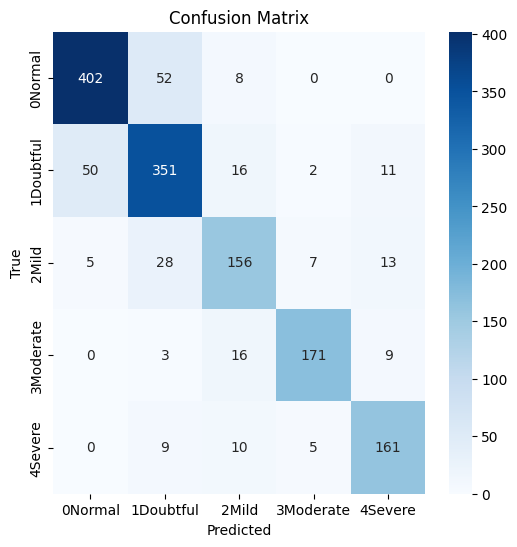


Classification Report:
               precision    recall  f1-score   support

     0Normal       0.88      0.87      0.87       462
   1Doubtful       0.79      0.82      0.80       430
       2Mild       0.76      0.75      0.75       209
   3Moderate       0.92      0.86      0.89       199
     4Severe       0.83      0.87      0.85       185

    accuracy                           0.84      1485
   macro avg       0.84      0.83      0.83      1485
weighted avg       0.84      0.84      0.84      1485



In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Multiply, Add, GlobalMaxPooling2D, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda
import tensorflow as tf
from tensorflow.keras.layers import Concatenate
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Add, Activation, Reshape, Multiply, Lambda, Conv2D
)

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load CSV with image paths and labels
df_train = pd.read_csv("train_data_expert1.csv")
df_val = pd.read_csv("val_data_expert1.csv")
df_test = pd.read_csv("test_data_expert1.csv")

# Define image dimensions and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_dataframe(
    df_train,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = datagen.flow_from_dataframe(
    df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = datagen.flow_from_dataframe(
    df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# ==============================
# CBAM Attention Module
# ==============================
from tensorflow.keras.saving import register_keras_serializable

# ✅ Register Functions
@register_keras_serializable()
def mean_layer(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

@register_keras_serializable()
def max_layer(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

def cbam_block(input_tensor, ratio=8):
    channel_dim = input_tensor.shape[-1]

    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(input_tensor)
    channel_max = GlobalMaxPooling2D()(input_tensor)

    channel_avg = Dense(channel_dim // ratio, activation='relu')(channel_avg)
    channel_avg = Dense(channel_dim, activation='sigmoid')(channel_avg)

    channel_max = Dense(channel_dim // ratio, activation='relu')(channel_max)
    channel_max = Dense(channel_dim, activation='sigmoid')(channel_max)

    channel_att = Add()([channel_avg, channel_max])
    channel_att = Activation('sigmoid')(channel_att)
    channel_att = Reshape((1, 1, channel_dim))(channel_att)
    channel_att = Multiply()([input_tensor, channel_att])

    # ✅ Use Registered Lambda Layers
    spatial_avg = Lambda(mean_layer)(channel_att)
    spatial_max = Lambda(max_layer)(channel_att)

    spatial_att = Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_att = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(spatial_att)
    spatial_att = Multiply()([channel_att, spatial_att])

    return spatial_att


# ==============================
# Load Pretrained DenseNet121 Model
# ==============================
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers (for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# ✅ Apply CBAM Attention (Fixed)
x = cbam_block(base_model.output)

# Fully Connected Layers
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation="softmax")(x)

# Create Final Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ==============================
# Train Model
# ==============================
EPOCHS = 100
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)

# Save Model
model.save("densenet121_cbam_knee_xray_classifier.h5")
print("Training complete! Model saved.")

# ==============================
# Print Training & Validation Accuracy for Each Epoch
# ==============================
print("\nEpoch-wise Training & Validation Accuracy:")
for epoch in range(EPOCHS):
    train_acc = history.history["accuracy"][epoch]
    val_acc = history.history["val_accuracy"][epoch]
    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

# ==============================
#  Confusion Matrix on Test Data
# ==============================
# Predict test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class index with highest probability
y_true = test_gen.classes  # True class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ==============================
#  Classification Report
# ==============================
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("\nClassification Report:\n", report)


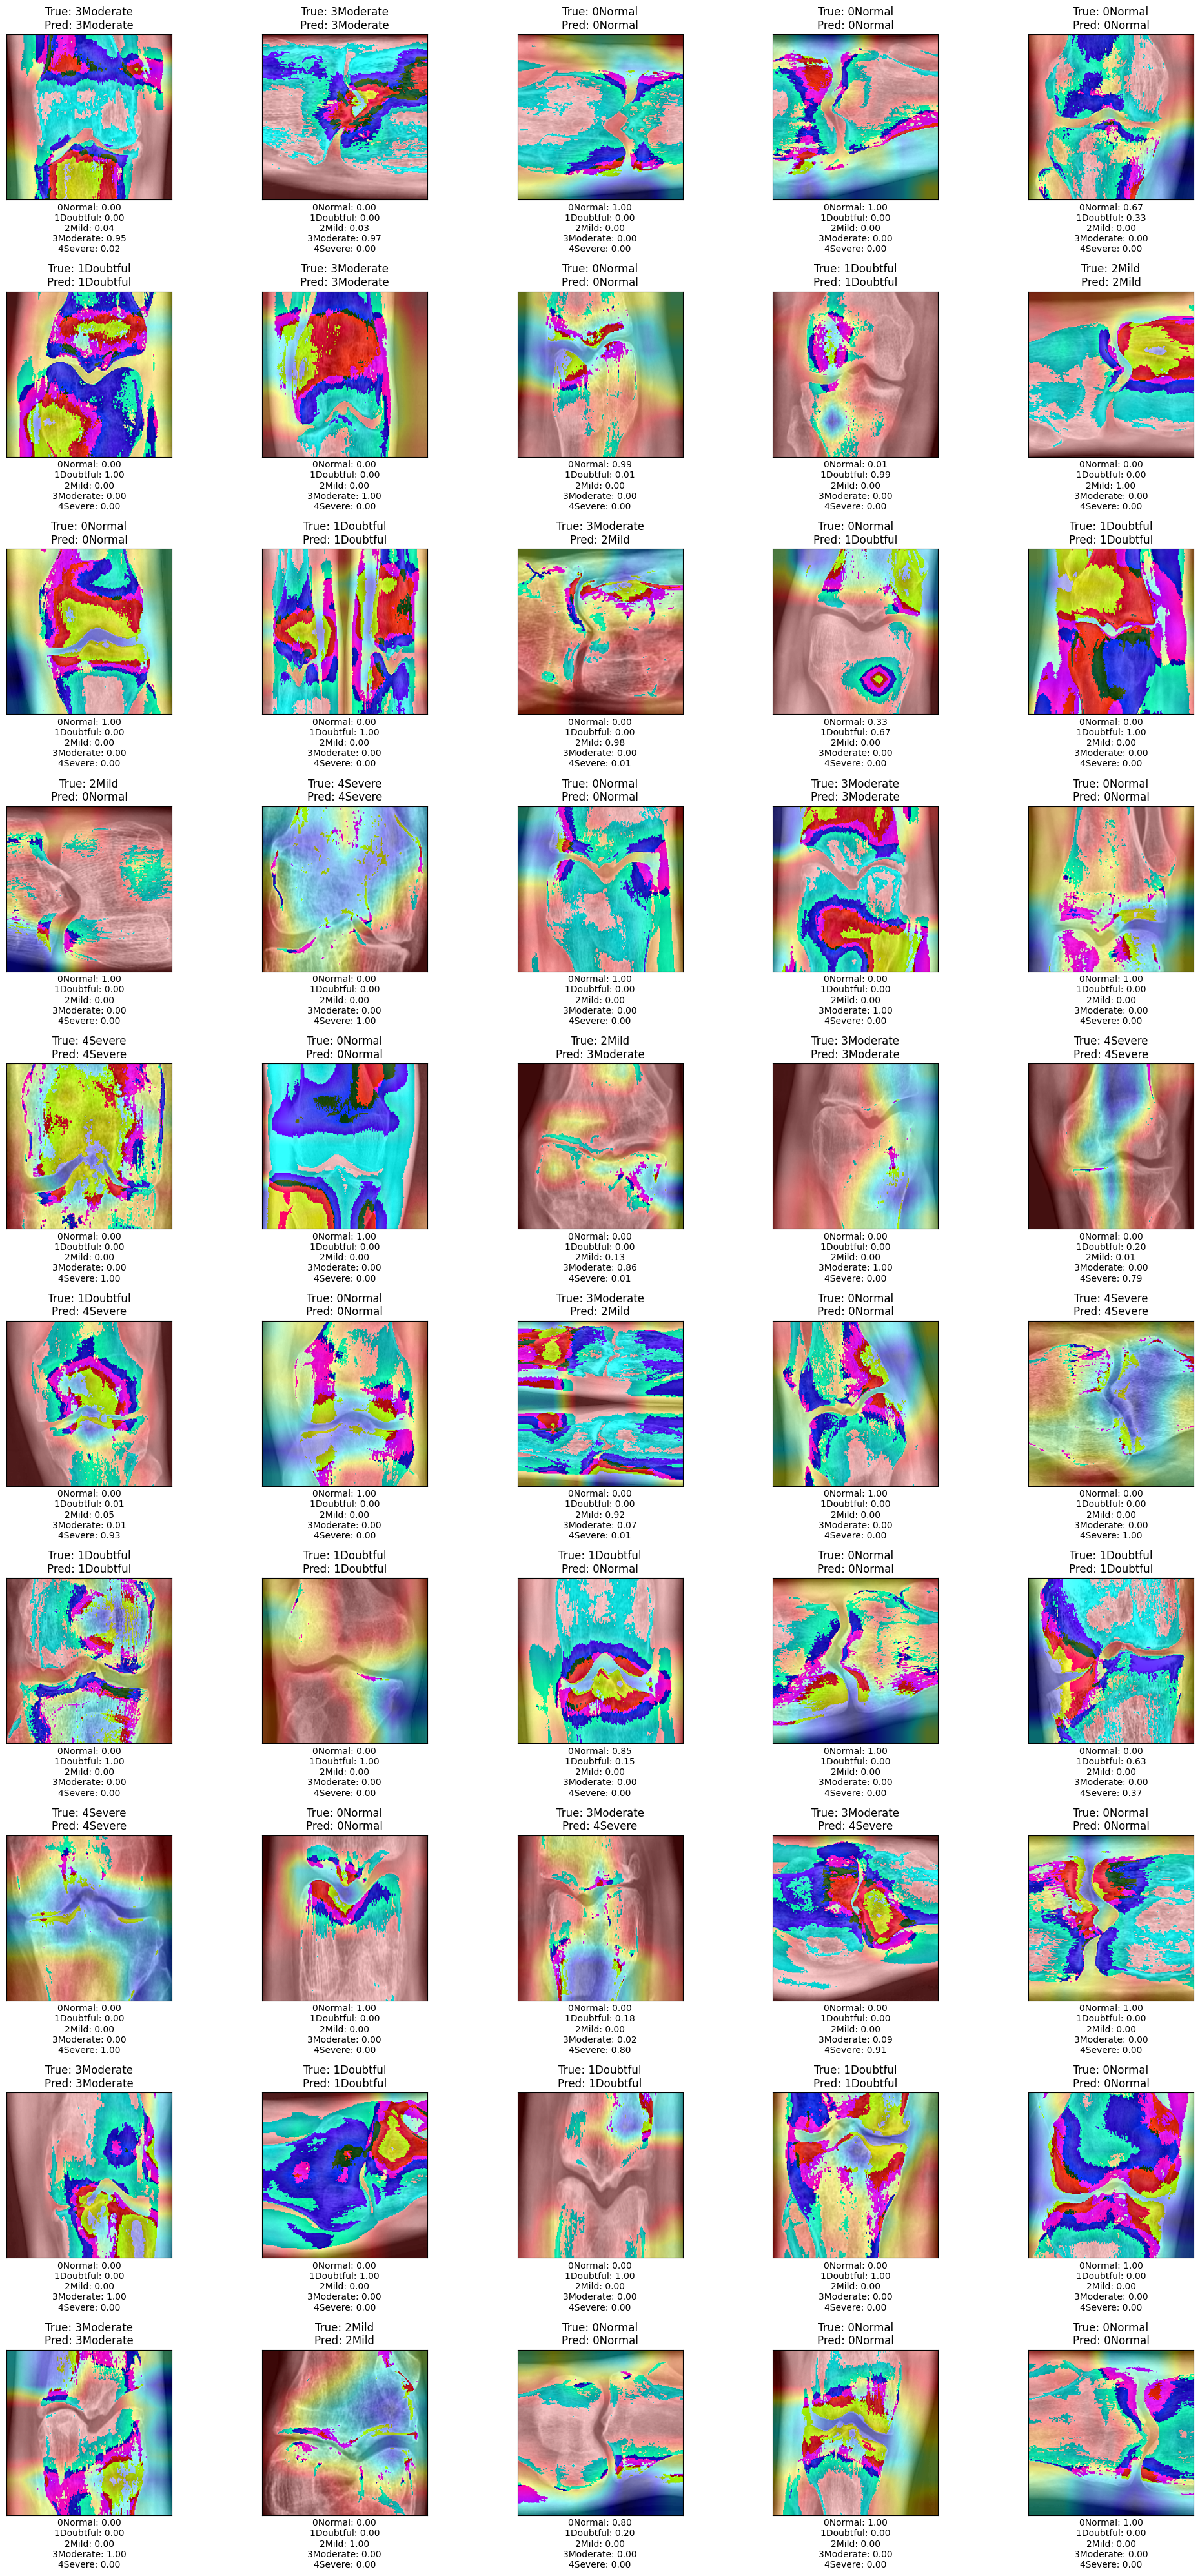

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# ==============================
#  Function to Generate Grad-CAM
# ==============================
def get_grad_cam(img_array, model, class_index):
    """Generate Grad-CAM heatmap for a given image and model"""
    conv_layer = "conv5_block16_concat"  # Last conv layer in DenseNet121

    # Create a model that maps input -> (conv layer output, final prediction)
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # Focus on the predicted class

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Convert to NumPy
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    # Weight each channel by importance
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Compute heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# ==============================
#  Overlay Heatmap on Original Image
# ==============================
def overlay_gradcam(image, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap onto original image"""
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 scale
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Superimpose heatmap onto image
    superimposed_img = heatmap * alpha + image
    return np.uint8(superimposed_img)

# ==============================
#  Generate Grad-CAM for 50 Test Images
# ==============================
plt.figure(figsize=(20, 40))
num_images = 50  # Set to 50 test images

for i in range(num_images):
    img_path = test_gen.filepaths[i]  # Get image path
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)  # Prepare for model

    y_pred = model.predict(img_input, verbose=0)[0]
    pred_class = np.argmax(y_pred)

    # Generate Grad-CAM heatmap
    heatmap = get_grad_cam(img_input, model, pred_class)

    # Overlay heatmap
    image_with_heatmap = overlay_gradcam(img_array * 255, heatmap)

    # Display results
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns
    plt.imshow(image_with_heatmap)
    plt.title(f"True: {list(test_gen.class_indices.keys())[test_gen.classes[i]]}\nPred: {list(test_gen.class_indices.keys())[pred_class]}")

    # Display probability scores for each class
    prob_text = "\n".join([f"{cls}: {prob:.2f}" for cls, prob in zip(test_gen.class_indices.keys(), y_pred)])
    plt.xlabel(prob_text, fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


Model loaded successfully!
Class labels (from training): ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


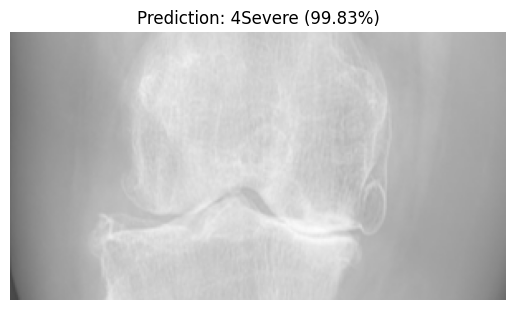

Predicted Class: 4Severe, Confidence: 1.00


In [26]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ✅ Ensure preprocessing is the same as used during training
def crop_knee_joint(image):
    """Crop the knee joint ROI based on contour detection."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = image[y:y+h, x:x+w]
        return cv2.resize(roi, (224, 224))  # Resize to match training
    else:
        return cv2.resize(image, (224, 224))  # Default to resized full image

def augment_knee_joint(image):
    """Apply knee-focused contrast and brightness augmentation."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return image

def preprocess_image(image_path):
    """Full preprocessing pipeline: Read, Crop, Augment, Normalize."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")

    img = crop_knee_joint(img)  # Crop knee joint
    img = augment_knee_joint(img)  # Apply knee-focused contrast adjustments
    img = img / 255.0  # Normalize pixel values (0-1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)

    return img

# ✅ Load the trained model with CBAM block
from tensorflow.keras.models import load_model

model = load_model(
    "densenet121_cbam_knee_xray_classifier.h5",
    custom_objects={"cbam_block": cbam_block, "mean_layer": mean_layer, "max_layer": max_layer, "tf": tf}
)
print("Model loaded successfully!")

# ✅ Get correct class labels from the training generator
class_labels = list(test_gen.class_indices.keys())  # Ensure correct order
print(f"Class labels (from training): {class_labels}")

def predict_image(image_path):
    """Preprocess image, make prediction, and display results."""
    img = preprocess_image(image_path)
    predictions = model.predict(img)  # Predict class probabilities

    predicted_class_idx = np.argmax(predictions)  # Get class index with highest probability
    confidence = predictions[0][predicted_class_idx]  # Get confidence score
    predicted_label = class_labels[predicted_class_idx]  # Map index to class name

    # Display the image with prediction
    img_display = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
    plt.show()

    return predicted_label, confidence

# ==============================
# 🔹 Upload Image & Predict
# ==============================
image_path = "/content/SevereG4 (163).png"
predicted_label, confidence_score = predict_image(image_path)

print(f"Predicted Class: {predicted_label}, Confidence: {confidence_score:.2f}")
